# 💡 faster R-CNN 돌리기  



# ⚽️ 준비하기: 라이브러리 다운로드. 




In [1]:
# 2️⃣MMdetection 다운로드
import torch
print(torch.__version__)

1.9.1+cu111


In [2]:
!pip install mmcv-full==1.6.0 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9/index.html

!git clone https://github.com/open-mmlab/mmdetection
%cd mmdetection

!pip install -e .

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9/index.html
fatal: destination path 'mmdetection' already exists and is not an empty directory.
/aiffel/aiffel/mmdetection
Obtaining file:///aiffel/aiffel/mmdetection
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmdet
    Found existing installation: mmdet 2.26.0
    Uninstalling mmdet-2.26.0:
      Successfully uninstalled mmdet-2.26.0
  Running setup.py develop for mmdet


In [3]:
# 완디비 설치
!pip install -q --upgrade wandb

In [4]:
import os
import os.path as osp
import torch
import torchvision
import numpy as np

# MMDetection
import mmdet
print(mmdet.__version__)
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from mmdet.apis import set_random_seed

# MMCV
import mmcv
from mmcv import Config

# # Weights and Biases
import wandb
print(wandb.__version__)

2.26.0
0.13.5


In [5]:
# 완디비 로그인
wandb.login(key= 'f8874be2e62d97b00e02f959f8ae21da6d43513d')

wandb: Currently logged in as: yunjeongdeok. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [6]:
# from mmdet.datasets.builder import DATASETS
# from mmdet.datasets.coco import CocoDataset

# @DATASETS.register_module(force=True)
# class Aimmo(CocoDataset):
#      CLASSES = ('car', 'truck', 'bus','pedestrian')

In [7]:
import copy
import os.path as osp
import cv2

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# 반드시 아래 Decorator 설정 할것.@DATASETS.register_module() 설정 시 force=True를 입력하지 않으면 Dataset 재등록 불가. 
@DATASETS.register_module(force=True)
class Aimmo(CustomDataset):
    CLASSES = ('car', 'truck', 'bus','pedestrian')
  
  ##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
  #### ann_file: /content/kitti_tiny/train.txt
  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고, 이 self.ann_file이 load_annotations()의 인자로 입력
    def load_annotations(self, ann_file):
        print('##### self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
        print('#### ann_file:', ann_file)
        cat2label = {k:i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
        # 포맷 중립 데이터를 담을 list 객체
        data_infos = []
    
        for image_id in image_list:
            filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id)
            # 원본 이미지의 너비, 높이를 image를 직접 로드하여 구함. 
            image = cv2.imread(filename)
            height, width = 960, 512
            # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename 에는 image의 파일명만 들어감(디렉토리는 제외)
            data_info = {'filename': str(image_id) + '.png',
                       'width': width, 'height': height}
            # 개별 annotation이 있는 서브 디렉토리의 prefix 변환. 
            label_prefix = self.img_prefix.replace('img', 'label')
            # 개별 annotation 파일을 1개 line 씩 읽어서 list 로드 
            lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+'.txt'))

            # 전체 lines를 개별 line별 공백 레벨로 parsing 하여 다시 list로 저장. content는 list의 list형태임.
            # ann 정보는 numpy array로 저장되나 텍스트 처리나 데이터 가공이 list 가 편하므로 일차적으로 list로 변환 수행.   
            content = [line.strip().split(' ') for line in lines]
            # 오브젝트의 클래스명은 bbox_names로 저장. 
            bbox_names = [x[0] for x in content]
            # bbox 좌표를 저장
            bboxes = [ [float(info) for info in x[1:5]] for x in content]

            # 클래스명이 해당 사항이 없는 대상 Filtering out, 'DontCare'sms ignore로 별도 저장.
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []

            for bbox_name, bbox in zip(bbox_names, bboxes):
                # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
                if bbox_name in cat2label:
                    gt_bboxes.append(bbox)
                    # gt_labels에는 class id를 입력
                    gt_labels.append(cat2label[bbox_name])
                else:
                    gt_bboxes_ignore.append(bbox)
                    gt_labels_ignore.append(-1)
            # 개별 image별 annotation 정보를 가지는 Dict 생성. 해당 Dict의 value값은 모두 np.array임. 
            data_anno = {
              'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
              'labels': np.array(gt_labels, dtype=np.compat.long),
              'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
              'labels_ignore': np.array(gt_labels_ignore, dtype=np.compat.long)
            }

            # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장. 
            data_info.update(ann=data_anno)
            # 전체 annotation 파일들에 대한 정보를 가지는 data_infos에 data_info Dict를 추가
            data_infos.append(data_info)
        # print(f'data_infos이다{data_infos}')
#         print(f'data_infos입니다{data_infos}',sep='\n')
#         print(f'bboxes입니다{bboxes}')
#         print(f'gt_labels입니다{gt_labels}')
        return data_infos


In [8]:
pwd

'/aiffel/aiffel/mmdetection'

In [9]:
config_file = '/aiffel/aiffel/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/aiffel/aiffel/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [10]:
!cd /aiffel/aiffel/mmdetection; mkdir checkpoints
!wget -O /aiffel/aiffel/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-12-05 03:31:47--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.59
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/aiffel/aiffel/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/aiffel/aiffel/mmde 100%[===================>] 159.54M  10.6MB/s    in 15s     

2022-12-05 03:32:03 (10.5 MB/s) - ‘/aiffel/aiffel/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [11]:
from mmcv import Config

cfg = Config.fromfile(config_file)
# print(cfg.pretty_text)

In [12]:
!pwd
# !ls

/aiffel/aiffel/mmdetection


# 하이퍼 파라미터 수정

In [13]:
from mmdet.apis import set_random_seed
import copy
import os.path as osp
import cv2

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset


# dataset에 대한 환경 파라미터 수정.
cfg.dataset_type = 'Aimmo'


cfg.data_root = '/aiffel/aiffel/aimmo/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'Aimmo'
cfg.data.train.data_root = '/aiffel/aiffel/aimmo/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'img'


cfg.data.val.type = 'Aimmo'
cfg.data.val.data_root = '/aiffel/aiffel/aimmo/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'img'


cfg.data.test.type = 'Aimmo'
cfg.data.test.data_root = '/aiffel/aiffel/aimmo/'
cfg.data.test.ann_file = 'test.txt'
cfg.data.test.img_prefix = 'img'



# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4

# pretrained 모델
cfg.load_from = '/aiffel/aiffel/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = '/aiffel/aiffel/03_epoch3_/'

# 에포크 체크포인트 = 이어서 학습하기
# cfg.resume_from = '/aiffel/aiffel/03_epoch3_/epoch_1.pth'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 3
# cfg.optimizer =  dict(type='Adam', lr=0.0003, weight_decay=0.0001)


# CustomDataset은 'mAP'이고 CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 1 # 
cfg.checkpoint_config.interval = 1


# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'


# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'

cfg.data.samples_per_gpu = 2 # Batch size of a single GPU used in testing
cfg.data.workers_per_gpu = 2 # Worker to pre-fetch data for each single GPU
cfg.runner.max_epochs = 50 # 에포크 수




In [14]:
## 수정된 모델 확인
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [15]:
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='WandbLoggerHook',
         init_kwargs={'project': 'Faster R-CNN',
                      'entity': 'aimmoya',
                      'name': '에포크 50, 성공해주세요ㅠㅠ',
                      'tags': ['Faster R-CNN', 'epoch50', 'default']})]

In [16]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

##### self.data_root: /aiffel/aiffel/aimmo/ self.ann_file: /aiffel/aiffel/aimmo/train.txt self.img_prefix: /aiffel/aiffel/aimmo/img
#### ann_file: /aiffel/aiffel/aimmo/train.txt


/aiffel/aiffel/mmdetection/mmdet/datasets/custom.py:181: UserWarning: CustomDataset does not support filtering empty gt images.
  warnings.warn(


In [17]:
print(datasets[0])
# datasets[0].__sdict__ 로 모든 self variables의 key와 value값을 볼 수 있음. 
datasets[0].__dict__.keys()


Aimmo Train dataset with number of images 8000, and instance counts: 
+----------+-------+-----------+-------+----------+-------+----------------+-------+---------------+-------+
| category | count | category  | count | category | count | category       | count | category      | count |
+----------+-------+-----------+-------+----------+-------+----------------+-------+---------------+-------+
| 0 [car]  | 43095 | 1 [truck] | 8863  | 2 [bus]  | 5423  | 3 [pedestrian] | 16381 | -1 background | 0     |
+----------+-------+-----------+-------+----------+-------+----------------+-------+---------------+-------+


dict_keys(['ann_file', 'data_root', 'img_prefix', 'seg_prefix', 'seg_suffix', 'proposal_file', 'test_mode', 'filter_empty_gt', 'file_client', 'CLASSES', 'data_infos', 'proposals', 'flag', 'pipeline'])

In [ ]:
print(len(datasets[0].data_infos))

In [ ]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

In [ ]:
# 주의, config에 pretrained 모델 지정이 상대 경로로 설정됨 cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# 아래와 같이 %cd mmdetection 지정 필요. 
 
%cd /aiffel/aiffel/mmdetection

# Create work_dir
# mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# epochs는 config의 runner 파라미터로 지정됨. 기본 12회, 현재는 50으로 맞췄다. 
train_detector(model, datasets, cfg, distributed=False, validate=True)

In [ ]:
pwd

## 테스트 데이터 세트에 Inference 및 Evaluation 적용하기
* 런타임 다시 시작 수행 필요(버그?)
* tools/test.py 스크립트는 colab에서 오류 발생
* 테스트용 Dataset과 DataLoader생성하고 single_gpu_test()를 호출하여 inference 결과를 반환. batch_size를 1로 설정하지 않으면 single_gpu_test() 오류 발생. 

In [18]:
from mmdet.apis import set_random_seed
import copy
import os.path as osp
import cv2

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset


# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'Aimmo'


cfg.data_root = '/aiffel/aiffel/aimmo/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'Aimmo'
cfg.data.train.data_root = '/aiffel/aiffel/aimmo/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'img'


cfg.data.val.type = 'Aimmo'
cfg.data.val.data_root = '/aiffel/aiffel/aimmo/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'img'


cfg.data.test.type = 'Aimmo'
cfg.data.test.data_root = '/aiffel/aiffel/aimmo/'
cfg.data.test.ann_file = 'test.txt'
cfg.data.test.img_prefix = 'img'



# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4

# pretrained 모델
cfg.load_from = '/aiffel/aiffel/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = '/aiffel/aiffel/03_epoch3_/'

# 에포크 체크포인트 = 이어서 학습하기
# cfg.resume_from = '/aiffel/aiffel/03_epoch3_/epoch_1.pth'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 3
# cfg.optimizer =  dict(type='Adam', lr=0.0003, weight_decay=0.0001)


# CustomDataset은 'mAP'이고 CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 1 # 
cfg.checkpoint_config.interval = 1


# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'


# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'

cfg.data.samples_per_gpu = 1 # Batch size of a single GPU used in testing
cfg.data.workers_per_gpu = 1 # Worker to pre-fetch data for each single GPU
cfg.runner.max_epochs = 50 # 에포크 수




In [ ]:
cfg.dump('/aiffel/aiffel/03_epoch3_/aimmo_faster_rcnn_conf.py')

In [19]:
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

# test용 Dataset과 DataLoader 생성. 
# build_dataset()호출 시 list로 감싸지 않는 것이 train용 dataset 생성시와 차이. 
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        # 반드시 아래 samples_per_gpu 인자값은 1로 설정
        samples_per_gpu=cfg.data.samples_per_gpu,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

# 반드시 아래 코드에서 'img' 키값이 tensor로 출력되어야 함. 
next(iter(data_loader))

##### self.data_root: /aiffel/aiffel/aimmo/ self.ann_file: /aiffel/aiffel/aimmo/test.txt self.img_prefix: /aiffel/aiffel/aimmo/img
#### ann_file: /aiffel/aiffel/aimmo/test.txt


{'img_metas': [DataContainer([[{'filename': '/aiffel/aiffel/aimmo/img/1654752843340_FR-View-CMR-Wide.png', 'ori_filename': '1654752843340_FR-View-CMR-Wide.png', 'ori_shape': (512, 960, 3), 'img_shape': (512, 960, 3), 'pad_shape': (512, 960, 3), 'scale_factor': array([1., 1., 1., 1.], dtype=float32), 'flip': False, 'flip_direction': None, 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}]])],
 'img': [tensor([[[[-0.2684, -0.2513, -0.2684,  ...,  0.3652, -0.0116, -0.4226],
            [-0.3883, -0.3712, -0.3027,  ...,  0.3309, -0.0972, -0.5938],
            [-0.3712, -0.3883, -0.3198,  ...,  0.2453, -0.4226, -0.9363],
            ...,
            [-1.7925, -1.8097, -1.8268,  ..., -1.4329, -1.4843, -1.5185],
            [-1.8439, -1.8439, -1.8268,  ..., -1.4329, -1.5014, -1.5357],
            [-1.8610, -1.8268, -1.7925,  ..., -1.4329, -1.4329, -1.5014]],
  
           [[ 0.0826,  0.1001,  0.0

In [20]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

checkpoint_file = '/aiffel/aiffel/weight_default_에폭 50/epoch_49.pth' 

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

load checkpoint from local path: /aiffel/aiffel/weight_default_에폭 50/epoch_49.pth


[                                                  ] 0/400, elapsed: 0s, ETA:

TypeError: can only concatenate str (not "int") to str

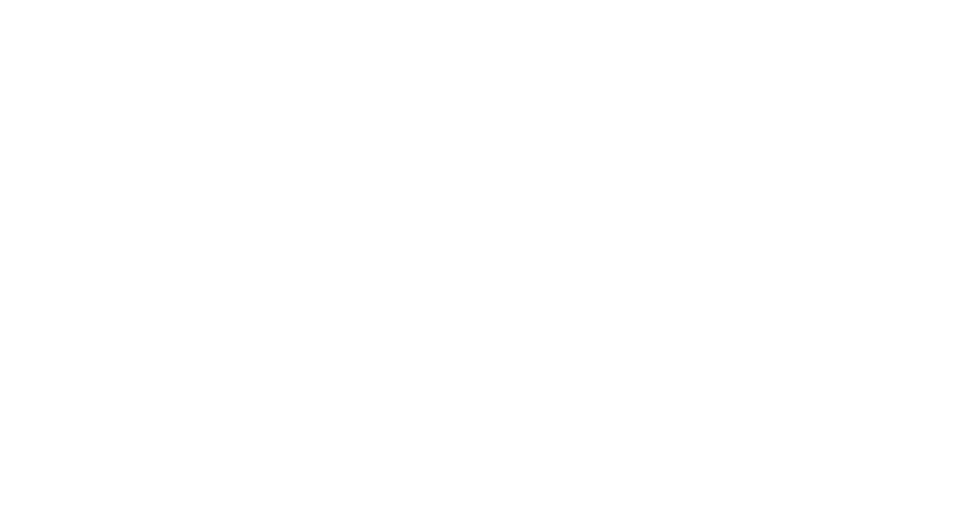

In [21]:
from mmdet.apis import multi_gpu_test, single_gpu_test
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

model_ckpt = MMDataParallel(model_ckpt, device_ids=[0])
# single_gpu_test() 를 호출하여 test데이터 세트의 interence 수행. 반드시 batch size는 1이 되어야 함. 
# 위에서 만든 /content/show_test_output 디렉토리에 interence 결과가 시각화된 이미지가 저장됨. 
outputs = single_gpu_test(model_ckpt, data_loader, True, '/aiffel/aiffel/abc', 0.3)